# Quantum Excess Evaluation Algorithm
Implementing [Quantum Computational Insurance and Actuarial Science](https://arxiv.org/html/2410.20841v1#S7.SS1)

## Define Parameters

In [1]:
# ██████   █████  ██████   █████  ███    ███ ███████ 
# ██   ██ ██   ██ ██   ██ ██   ██ ████  ████ ██      
# ██████  ███████ ██████  ███████ ██ ████ ██ ███████ 
# ██      ██   ██ ██   ██ ██   ██ ██  ██  ██      ██ 
# ██      ██   ██ ██   ██ ██   ██ ██      ██ ███████ 

# 6 qubits for demonstration, scalable approach
num_qubits = 6
# Define the domain of the distribution,
# we only operate on the range [0, 10]
domain_min = 0
domain_max = 10
deductible = 1.0  # Deductible amount (amount of full retention)
coins = 0.6  # Coinsurance rate (% retained by the cedent)
# for rotation gates (paper says "a small value")
c_param = 0.015

# Define lognormal distribution parameters
μ = 0.0  # Scale parameter
σ = 1.0  # Shape parameter

# Discretize domain into 2^num_qubits points
N = 2**num_qubits

## State Preparation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm
from scipy.special import erf
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import StatePreparation
from qiskit.visualization import plot_histogram


def lognormal_loss(x):
    """Lognormal loss function"""
    return lognorm.pdf(x, σ, loc=0, scale=np.exp(μ))


def analytic_binned_moment(bin_edges, μ, σ):
    """
    Computes for each bin defined by bin_edges:
    - pmf: P(X in [edges[i], edges[i+1]])
    - mean: ∫_edges[i]^[i+1] x f(x) dx (first moment over the bin)
    Distribution: LogNormal with log-mean mu and log-std sigma.

    Parameters
    ----------
    bin_edges : array-like, shape (N+1,)
        The edges of the bins.
    μ : float
        Mean of the underlying normal distribution (log-domain).
    σ : float
        Standard deviation of the underlying normal distribution (log-domain).

    Returns
    -------
    pmf : ndarray, shape (N,)
        Probability mass in each bin.
    bin_mean : ndarray, shape (N,)
        Exact first moment (∫ x f(x) dx) over each bin.
    """
    edges = np.asarray(bin_edges)
    a = edges[:-1]
    b = edges[1:]

    # CDF of the lognormal via the normal CDF
    def Φ(z): return 0.5 * (1 + erf(z / np.sqrt(2)))

    # Standardize a and b
    z_lo = (np.log(a) - μ) / σ
    z_hi = (np.log(b) - μ) / σ

    # Probability mass per bin
    pmf = Φ(z_hi) - Φ(z_lo)

    # First moment: E[X * I(a <= X < b)] =
    # exp(μ + σ^2/2) * [Φ(z_hi - σ) - Φ(z_lo - σ)]
    z_lo_shift = (np.log(a) - μ - σ**2) / σ
    z_hi_shift = (np.log(b) - μ - σ**2) / σ
    prefactor = np.exp(μ + σ**2 / 2)
    bin_mean = prefactor * (Φ(z_hi_shift) - Φ(z_lo_shift))

    return pmf, bin_mean


def lognormal_loss_discretized(domain_min, domain_max, N):
    """Lognormal loss function for discretized values
    Lognormal is peaked on the left, so Riemannian approaches break down.
    We compute the density in each bin directly via:
    ∫ x f(x) dx"""
    # 1) Compute the bins and midpoints
    # build N equal‐width bins on [domain_min, domain_max]
    bin_edges = np.linspace(domain_min, domain_max, N + 1)
    step = (domain_max - domain_min) / N
    mid_x_vals = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # 2) Compute the bin probabilities using the analytic function
    pmf, bin_mean = analytic_binned_moment(bin_edges, μ, σ)

    # excess_per_bin = bin_mean - deductible * pmf
    # excess_per_bin[ mid_x_vals - step/2  < deductible ] = 0.0
    # classical_excess = coins * np.sum(excess_per_bin)

    # 3) compute left/right edges
    left_edges = bin_edges[:-1]
    right_edges = bin_edges[1:]

    # 4) initialize
    excess_per_bin = np.zeros_like(bin_mean)

    # 5) full‐bins above the deductible
    full_mask = left_edges >= deductible
    excess_per_bin[full_mask] = (
        bin_mean[full_mask] - deductible * pmf[full_mask]
    )

    # 6) the one bin that straddles d: a ∈ [left, d], b ∈ [d, right]
    #    find its index
    idx = np.searchsorted(left_edges, deductible) - 1
    if 0 <= idx < len(bin_mean):
        # integrate analytically over [d, right_edges[idx]]
        pmf_part, mean_part = analytic_binned_moment(
            [deductible, right_edges[idx]], μ, σ
        )
        excess_per_bin[idx] = mean_part - deductible * pmf_part

    expected_payout = (1 - coins) * excess_per_bin.sum()

    pmf /= np.sum(pmf)  # Normalize to sum to 1
    return pmf, mid_x_vals, step, expected_payout


probabilities, mid_x_vals, step, expected_payout = lognormal_loss_discretized(
    domain_min, domain_max, N)

# Calculate amplitudes (square root of probabilities)
amplitudes = np.sqrt(probabilities)

# Display the first few amplitudes
print("First 10 amplitudes:")
for i in range(10):
    try:
        print(
            f"State |{i}⟩: √p_j = {amplitudes[i]:.6f}, p_j = {probabilities[i]:.6f}, value = {mid_x_vals[i]:.6f}")
    except IndexError:
        pass

# Index of the first grid‑point *above* the deductible
threshold_idx = np.searchsorted(mid_x_vals, deductible, side="right")
print('---------------------------')
print(f"threshold = {threshold_idx}")
print(f"binary threshold = {threshold_idx:0{num_qubits}b}")

First 10 amplitudes:
State |0⟩: √p_j = 0.179016, p_j = 0.032047, value = 0.078125
State |1⟩: √p_j = 0.302745, p_j = 0.091655, value = 0.234375
State |2⟩: √p_j = 0.320987, p_j = 0.103033, value = 0.390625
State |3⟩: √p_j = 0.309641, p_j = 0.095878, value = 0.546875
State |4⟩: √p_j = 0.290223, p_j = 0.084229, value = 0.703125
State |5⟩: √p_j = 0.269323, p_j = 0.072535, value = 0.859375
State |6⟩: √p_j = 0.249185, p_j = 0.062093, value = 1.015625
State |7⟩: √p_j = 0.230547, p_j = 0.053152, value = 1.171875
State |8⟩: √p_j = 0.213585, p_j = 0.045618, value = 1.328125
State |9⟩: √p_j = 0.198250, p_j = 0.039303, value = 1.484375
---------------------------
threshold = 6
binary threshold = 000110


C:\Users\alexf\AppData\Local\Temp\ipykernel_22804\2349657756.py:46: RuntimeWarning: divide by zero encountered in log
  z_lo = (np.log(a) - μ) / σ
C:\Users\alexf\AppData\Local\Temp\ipykernel_22804\2349657756.py:54: RuntimeWarning: divide by zero encountered in log
  z_lo_shift = (np.log(a) - μ - σ**2) / σ
C:\Users\alexf\AppData\Local\Temp\ipykernel_22804\2349657756.py:101: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  excess_per_bin[idx] = mean_part - deductible * pmf_part


### Visualize State Preparation

C:\Users\alexf\AppData\Local\Temp\ipykernel_22804\2349657756.py:46: RuntimeWarning: divide by zero encountered in log
  z_lo = (np.log(a) - μ) / σ
C:\Users\alexf\AppData\Local\Temp\ipykernel_22804\2349657756.py:54: RuntimeWarning: divide by zero encountered in log
  z_lo_shift = (np.log(a) - μ - σ**2) / σ
C:\Users\alexf\AppData\Local\Temp\ipykernel_22804\2349657756.py:101: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  excess_per_bin[idx] = mean_part - deductible * pmf_part


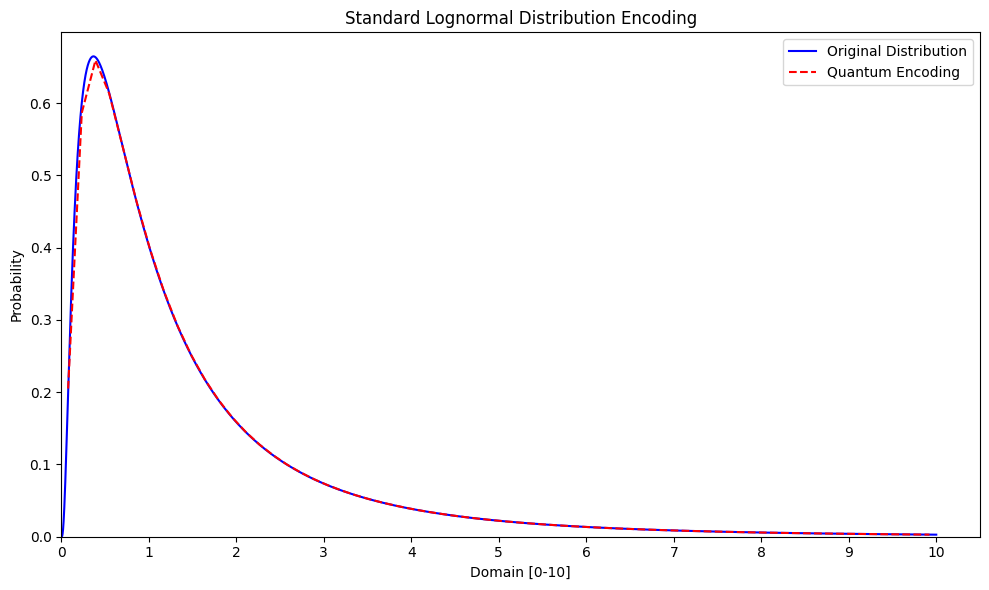

In [3]:
from qiskit_aer import AerSimulator


# Create quantum circuit for state preparation
qc_state_prep = QuantumCircuit(num_qubits)
qc_state_prep.append(StatePreparation(amplitudes), range(num_qubits))

# Validate our state preparation by measuring
backend = AerSimulator(method='statevector')
qc_state_prep = transpile(qc_state_prep, backend=backend, optimization_level=3)
qc_state_prep.save_statevector()
result = backend.run(qc_state_prep).result()
statevector = result.get_statevector(0)

# Calculate the resulting probabilities
measured_probs = np.abs(statevector)**2

# Create a "high resolution" distribution for comparison
high_res_probabilities, high_res_mid_x_vals, high_res_step, _ = lognormal_loss_discretized(
    domain_min, domain_max, 10_000)

# Plot the original distribution vs quantum encoded distribution
plt.figure(figsize=(10, 6))
plt.plot(high_res_mid_x_vals, high_res_probabilities /
        high_res_step, 'b-', label='Original Distribution')
plt.plot(mid_x_vals, measured_probs / step, 'r--', label='Quantum Encoding')
plt.xlabel('Domain [0-10]')
plt.ylabel('Probability')
plt.xticks(np.arange(domain_min, domain_max + 1, 1))
plt.title('Standard Lognormal Distribution Encoding')
plt.legend()
plt.tight_layout()
plt.axis([0, None, 0, None])
plt.show()

### Compare State Degeneration by Resolution

C:\Users\alexf\AppData\Local\Temp\ipykernel_22804\752892826.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Set1', len(num_qubits_list))


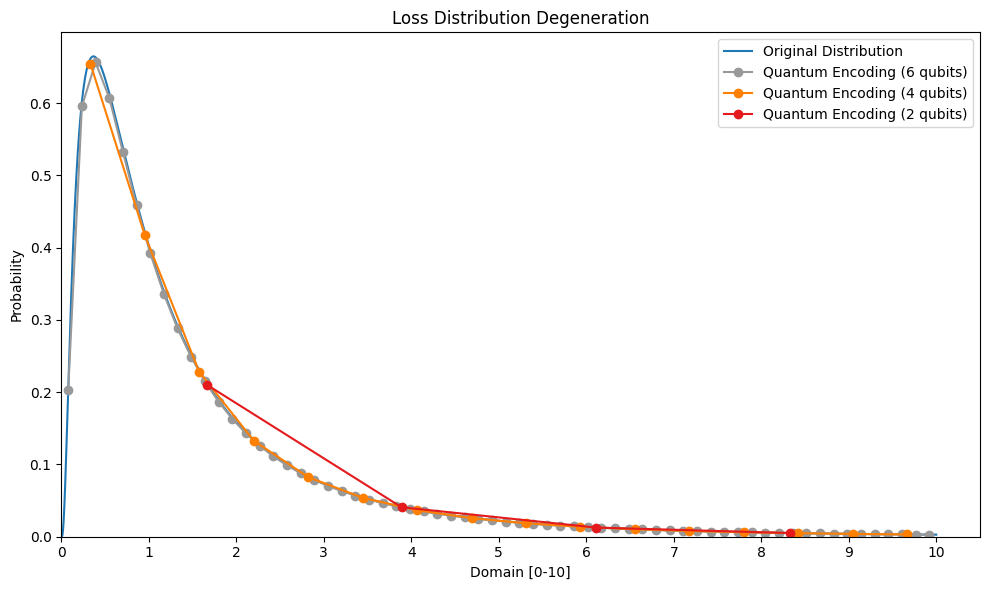

In [4]:
def plot_state_degeneration():
    num_qubits_list = [2, 4, 6]
    N_list = [2**n for n in num_qubits_list]
    step_list = [(domain_max - domain_min) / (N - 1) for N in N_list]
    # Take the midpoint integral approximation to work on small number of qubits
    mid_x_vals_list = [np.linspace(domain_min + step / 2, domain_max - step / 2, N) for step, N in zip(step_list, N_list)]
    probabilities_list = []
    for i, _ in enumerate(N_list):
        x_vals = mid_x_vals_list[i]
        step = step_list[i]
        p = np.array([lognormal_loss(x) * step for x in x_vals])
        p /= probabilities.sum()
        probabilities_list.append(p)

    # Add Color
    cmap = plt.cm.get_cmap('Set1', len(num_qubits_list))

    # Plot the original distribution vs quantum encoded distribution
    plt.figure(figsize=(10, 6))
    plt.plot(high_res_mid_x_vals, high_res_probabilities /
            high_res_step, '-', label='Original Distribution')
    for i, n in reversed(list(enumerate(num_qubits_list))):
        x_vals = mid_x_vals_list[i]
        step = step_list[i]
        p = probabilities_list[i]
        alpha = 1/(i/2 + 1)
        plt.plot(x_vals, p / step, 'o-', color=cmap(i), label=f'Quantum Encoding ({n} qubits)')
    plt.xlabel('Domain [0-10]')
    plt.ylabel('Probability')
    plt.xticks(np.arange(domain_min, domain_max + 1, 1))
    plt.title('Loss Distribution Degeneration')
    plt.legend()
    plt.tight_layout()
    plt.axis([0, None, 0, None])
    plt.show()


plot_state_degeneration()

## Quantum Subtractor

In [5]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library.data_preparation.state_preparation import StatePreparation
from qiskit.circuit.library.basis_change.qft import QFT


def make_subtractor(loss_reg, constant) -> QuantumCircuit:
    """
    Quantum circuit that maps |x> -> |x - constant mod 2^n>
    on `loss_reg`.

    Parameters
    ----------
    loss_reg : QuantumRegister (or list of Qubits)
        Register that stores an unsigned integer.
    constant : int
        Positive integer < 2^n to subtract.
    """
    n  = len(loss_reg)
    qc = QuantumCircuit(loss_reg, name=f"-{constant}")

    # 1) QFT (decomposed → gate)
    qft_circ = QFT(num_qubits=n, do_swaps=False)
    qft_decomp = qft_circ.decompose()
    qft_decomp = transpile(qft_decomp,
                            basis_gates=['u', 'cx'],
                            optimization_level=3)
    qft_gate   = qft_decomp.to_gate(label="QFT_decomp")
    qc.append(qft_gate, loss_reg)

    # 2) Phase shift: subtract constant via phases
    for k, qb in enumerate(loss_reg):
        angle = -2 * np.pi * constant / (2 ** (k + 1))
        qc.rz(angle, qb)

    # 3) Inverse QFT (decomposed → gate)
    inv_circ   = QFT(num_qubits=n, do_swaps=False).inverse()
    inv_decomp = inv_circ.decompose()
    inv_decomp = transpile(inv_decomp,
                            basis_gates=['u', 'cx'],
                            optimization_level=3)
    inv_gate = inv_decomp.to_gate(label="QFT_inv")
    qc.append(inv_gate, loss_reg)

    # 4) Reverse back to MSB-first
    for i in range(n // 2):
        qc.swap(loss_reg[i], loss_reg[n - 1 - i])

    return qc

### Set up the Circuit

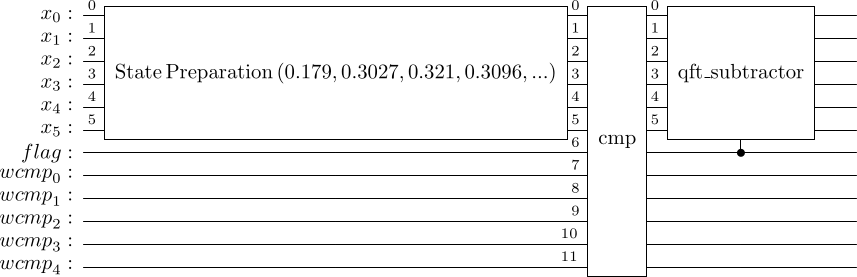

In [6]:
from qiskit.circuit.library.arithmetic.integer_comparator import IntegerComparator


# 1) State-prep
x_q = QuantumRegister(num_qubits, "x") # loss register
qc  = QuantumCircuit(x_q) # create a new circuit
qc.append(StatePreparation(amplitudes), x_q) # state-prep circuit

# 2) Comparator → flag  (MSB→LSB)
flag_q = QuantumRegister(1, "flag") # flag for comparator
wcmp_q = QuantumRegister(num_qubits-1, "wcmp") # workspace for comparator
qc.add_register(flag_q, wcmp_q) # add registers to circuit

# Define the comparator gate (compare to a constant)
cmp_gate = IntegerComparator(num_state_qubits=num_qubits,
                            value=threshold_idx,
                            geq=True)

# Append the comparator gate to the circuit
qc.append(cmp_gate,
        list(x_q)      # MSB→LSB
        + [flag_q[0]]  # then the flag
        + list(wcmp_q))

# 3) QFT-subtractor (controlled on the same flag)
#   subtract threshold mod 2^n via phases in the QFT basis
sub_circ = make_subtractor(x_q, threshold_idx)
sub_gate = sub_circ.to_gate(label="qft_subtractor") # convert to gate
# Create a controlled version of the subtractor gate.
# The subtraction only happens if the single control qubit is in state |1>,
# leaving it unchanged otherwise.
csub_gate = sub_gate.control(1)
# Append the controlled subtractor gate to the circuit
qc.append(csub_gate, [flag_q[0]] + list(x_q))

qc.draw(output='latex')

## Controlled Rotations

In [7]:
def add_payout_qubit_and_bias(qc: QuantumCircuit,
                                label: str = "payout_aux") -> QuantumRegister:
    """
    Allocate ONE fresh qubit at the end of `qc`
    Apply RY(π/2) so it starts in
        cos(π/4)|0> + sin(π/4)|1>
    Return the newly‑created QuantumRegister (length 1).
    """
    payout_aux = QuantumRegister(1, label)
    qc.add_register(payout_aux)
    # RY(π/2) on |0> → |+_y>
    # RY gate rotates the qubit around the Y axis
    # by an angle of π/2 radians (90 degrees).
    # This creates a superposition of |0> and |1> states
    # with equal probability amplitudes.
    # The resulting state is (|0> + |1>)/√2 = |+_y>
    qc.ry(np.pi / 2, payout_aux[0])
    return payout_aux


def _rotation_angle(excess_step, c):
    """
    Compute the exact rotation θ such that:
        state with probability ½ lifts to ½+Δ
    This yields θ = arcsin(2Δ)
    """
    Δ = c * excess_step  # how much we want to add to 0.5
    return np.arcsin(2 * Δ)


def apply_excess_rotations(
    qc: QuantumCircuit,
    excess_reg,
    flag_qubit,
    payout_qubit,
    step: float,
    c_param: float,
    little_endian: bool = True
) -> QuantumCircuit:
    """
    Apply controlled-RY rotations to the `payout_qubit` based on the
    `loss_reg` qubits. The rotations are controlled by the `flag_qubit`
    and are applied in the order of the qubits in `loss_reg`.

    Parameters:
    ----------
    qc : QuantumCircuit
        The quantum circuit to which the rotations will be added.
    excess_reg : QuantumRegister
        The quantum register holding the loss values.
    flag_qubit : Qubit
        The qubit that acts as the control for the rotations.
    payout_qubit : Qubit
        The qubit that will be rotated.
    step : float
        The step size for the rotations.
    c_param : float
        The parameter that determines the amount of rotation.
    little_endian : bool
        If True, the qubits are considered in little-endian order.
        If False, they are considered in big-endian order.
    """
    # Get total bits
    n_bits = len(excess_reg)

    # Apply rotations directly based on each qubit's position (weight)
    for k, q in enumerate(excess_reg):
        # Calculate the weight this bit represents in the excess value
        if little_endian:
            # In little-endian, the bit k represents 2^k
            weight = 1 << k
        else:
            # In big-endian, the bit k represents 2^(n-1-k)
            weight = 1 << (n_bits - 1 - k)

        # This is how much excess this bit position represents
        excess_value = weight * step

        # Calculate rotation angle
        θ = _rotation_angle(excess_value, c_param)

        ################################
        # Multi-Controlled-RY rotation #
        ################################
        # The mcry gate applies a controlled-RY rotation
        # to the target qubit (payout_qubit) based on the control qubits.
        # All the control qubits (flag_qubit and q) must be in the |1⟩ state.
        # Only rotate if flag is 1 (meaning value exceeds deductible)
        # AND this bit is 1 (contributes to excess)
        qc.mcry(θ, [flag_qubit, q], payout_qubit, None, mode='noancilla')

        ################################
        # Multi-Controlled-RZ rotation #
        ################################
        # The mcrz gate applies a controlled-RZ rotation
        # to the target qubit (payout_qubit) based on the control qubits.
        # All the control qubits (flag_qubit and q) must be in the |1⟩ state.
        # Only rotate if flag is 1 (meaning value exceeds deductible)
        # AND this bit is 1 (contributes to excess)
        # qc.mcrz(θ, [flag_qubit, q], payout_qubit, None)

    return qc

### Extend the Circuit

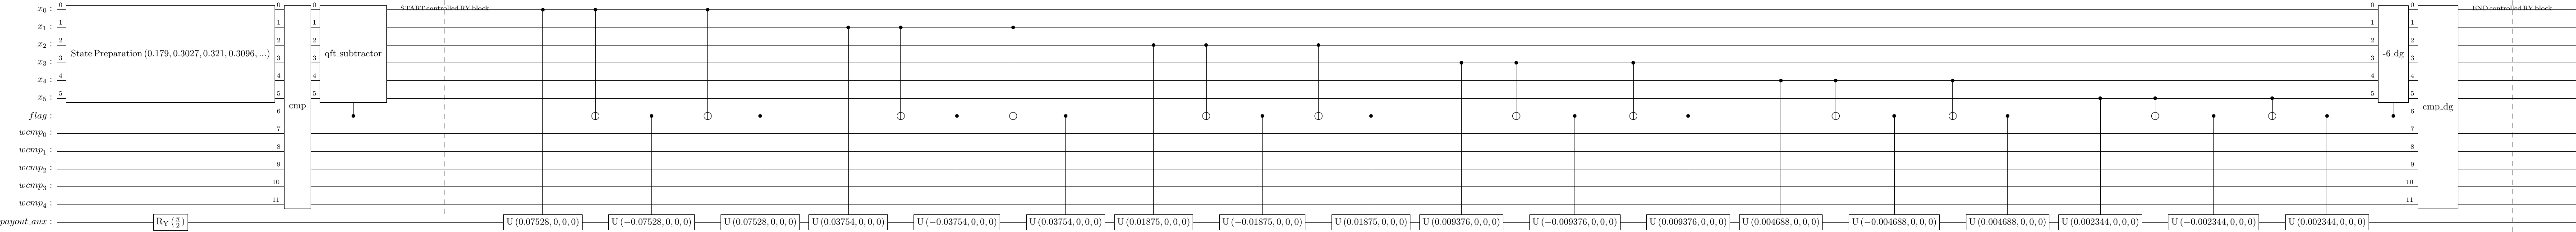

In [8]:
# Add a barrier to separate the controlled RY block
# (A barrier is just a visual aid in quantum circuits)
qc.barrier(label="START controlled RY block")

# 4) Process the excess
# Ancilla qubits are extra qubits added to a quantum circuit
# to facilitate certain operations or algorithms. 
payout_aux = add_payout_qubit_and_bias(qc)

# Apply Controlled-RY rotations, per the paper
qc = apply_excess_rotations(
    qc,
    excess_reg=x_q,
    flag_qubit=flag_q[0],
    payout_qubit=payout_aux[0],
    step=step,
    c_param=c_param,
    little_endian=False
)

# 5) Finalize the payout by uncomputing the gates
# This is necessary to remove the intermediate states
# and return the qubits to their original state.

# Uncompute the subtractor:
qc.append(csub_gate.inverse(), [flag_q[0]] + list(x_q))

# Uncompute the comparator:
qc.append(cmp_gate.inverse(), list(x_q) + [flag_q[0]] + list(wcmp_q))

# Add a barrier to separate the controlled RY block
qc.barrier(label="END controlled RY block")

qc.draw(output='latex')

## Iterative Amplitude Estimation

In [9]:
from qiskit.primitives import Sampler
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem


# 1) Prepare the state‐prep circuit for Amplitude Estimation (AE)
qc_ae = qc.copy()
# Avoid the qubit getting removed due to inactivity
qc_ae.id(payout_aux[0])
# remove final measurements
# this is needed to avoid errors when using the circuit in AE
qc_ae.remove_final_measurements()
qc_ae = qc_ae.decompose()  # decompose to basic gates
# Remove barriers and other non-quantum gates
qc_ae.data = [
    (inst, qargs, cargs)
    for inst, qargs, cargs in qc_ae.data
    if inst.name != "barrier"
]

# 2) Find the index of the payout auxiliary qubit in the original circuit
# This may change during decomposition because the qubit order may change
payout_idx = qc_ae.qubits.index(payout_aux[0])

# 3) Build and run the EstimationProblem using IterativeAmplitudeEstimation
# The IterativeAmplitudeEstimation class is used to perform amplitude estimation
# on the quantum circuit. It estimates the amplitude of the target state
# (in this case, the payout qubit) and provides a confidence interval for the estimate.
sampler = Sampler()  # Needed for AE to run, default is fine
iae = IterativeAmplitudeEstimation(
    epsilon_target=0.01,  # target error
    alpha=0.05,           # confidence level
    sampler=sampler
)

# A problem is a quantum circuit that prepares the state
problem = EstimationProblem(
    state_preparation=qc_ae,
    objective_qubits=[payout_idx]
)
result = iae.estimate(problem)

# Calculate results
ci_mean = (result.confidence_interval[0] + result.confidence_interval[1]) / 2
excess = (ci_mean - 0.5) / c_param
payout = (1 - coins) * excess

# Print results
print("Amplitude Estimation Results:")
print(f"QAE p_hat: {result.estimation:.6f}")
print(f"QAE confidence interval: [{result.confidence_interval[0]:.6f}, {result.confidence_interval[1]:.6f}]")
print(f"CI mean: {ci_mean:.6f}")
print(f"QAE excess (from CI mean): {excess:.6f}")
print(f"QAE payout (from CI mean): {payout:.6f}")

C:\Users\alexf\AppData\Local\Temp\ipykernel_22804\614117297.py:16: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, cargs in qc_ae.data
C:\Users\alexf\AppData\Local\Temp\ipykernel_22804\614117297.py:28: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()  # Needed for AE to run, default is fine


Amplitude Estimation Results:
QAE p_hat: 0.511067
QAE confidence interval: [0.511067, 0.511067]
CI mean: 0.511067
QAE excess (from CI mean): 0.737771
QAE payout (from CI mean): 0.295108


### Store Results

In [10]:
e_pmt_qubits = {
    2 : 0.225734,
    3 : 0.168208,
    4 : 0.207043,
    5 : 0.279911,
    6 : 0.295108,
    7 : 0.287726,
    8 : 0.291473,
    9 : 0.297171,
    10: 0.298134,
}

## Simulate from the Quantum Circuit

In [11]:
# import numpy as np
# import matplotlib.pyplot as plt
# from qiskit.primitives import StatevectorSampler
# from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
# from qiskit import transpile

# # Prepare data structures
# epsilon_targets = [0.1, 0.05, 0.02, 0.01, 0.005]

# # Results storage
# qae_results = []
# qae_shots_used = []

# # 1. Run Quantum AE with different precision levels
# for epsilon in epsilon_targets:
#     # Prepare the circuit
#     qc_ae = qc.copy()
#     qc_ae.id(payout_aux[0])
#     qc_ae.remove_final_measurements()
    
#     # Full decomposition to basic gates
#     qc_ae = transpile(qc_ae, basis_gates=['u1', 'u2', 'u3', 'cx'], optimization_level=3)
    
#     # Remove barriers if any
#     qc_ae.data = [
#         (inst, qargs, cargs)
#         for inst, qargs, cargs in qc_ae.data
#         if inst.name != "barrier"
#     ]
    
#     payout_idx = qc_ae.qubits.index(payout_aux[0])
    
#     # Run IAE with specified precision
#     sampler = StatevectorSampler()
#     iae = IterativeAmplitudeEstimation(
#         epsilon_target=epsilon,  # This controls precision
#         alpha=0.05,
#         sampler=sampler
#     )
    
#     problem = EstimationProblem(
#         state_preparation=qc_ae,
#         objective_qubits=[payout_idx]
#     )
#     result = iae.estimate(problem)
    
#     # Extract the actual number of shots used (if available)
#     total_shots = sum(result.shots)
#     qae_shots_used.append(total_shots)

#     # Calculate results and error
#     ci_mean = (result.confidence_interval[0] + result.confidence_interval[1]) / 2
#     excess = (ci_mean - 0.5) / c_param
#     payout = (1 - coins) * excess
#     qae_results.append(payout)

#     print(f"QAE with epsilon={epsilon}: used {total_shots} shots, payout={payout:.6f}")

## [Very Slow] Quantum Amplitude Estimation

In [12]:
# from qiskit import QuantumCircuit, ClassicalRegister, transpile
# from qiskit.primitives import Sampler
# from qiskit_algorithms import AmplitudeEstimation, EstimationProblem
# from qiskit_aer import AerSimulator

# # 1) Prepare the state‐prep circuit for Amplitude Estimation (AE)
# qc_ae = qc.copy()
# # Avoid the qubit getting removed due to inactivity
# qc_ae.id(payout_aux[0])
# # remove final measurements
# # this is needed to avoid errors when using the circuit in AE
# qc_ae.remove_final_measurements()
# qc_ae = qc_ae.decompose()  # decompose to basic gates
# # Remove barriers and other non-quantum gates
# qc_ae.data = [
#     (inst, qargs, cargs)
#     for inst, qargs, cargs in qc_ae.data
#     if inst.name != "barrier"
# ]

# # Find the index of the payout auxiliary qubit in the original circuit
# payout_idx = qc_ae.qubits.index(payout_aux[0])

# # 4) Build and run the EstimationProblem
# # Convert circuits into pure unitary Gates so AE can add controls
# state_prep_gate = qc_ae.to_gate(label="StatePrep")
# state_prep_gate.num_ancillas = 0  # no ancillas
# # A problem is a quantum circuit that prepares the state
# problem = EstimationProblem(
#     state_preparation=qc_ae,
#     objective_qubits=[payout_idx]
# )
# sampler = Sampler()  # Needed for AE to run, default is fine
# ae = AmplitudeEstimation(
#     num_eval_qubits=4,  # 3 is the default, more is slower but more accurate
#     sampler=sampler)
# result = ae.estimate(problem)  # run AE

# # 5) Compute and print the payout
# # p_hat = result.estimation
# # excess = (p_hat - 0.5)/c_param
# # payout = excess * coins

# # print(f"quantum payout = {payout}")

# # result.estimation doesn't pick up the rotation,
# # but the confidence interval does.
# # Calculate the mean of confidence interval as a potentially more accurate estimate
# ci_mean = (result.confidence_interval[0] + result.confidence_interval[1]) / 2

# # Print results
# print("\nAmplitude Estimation Results:")
# print(f"QAE p_hat: {result.estimation:.6f}")
# print(
#     f"QAE confidence interval: [{result.confidence_interval[0]:.6f}, {result.confidence_interval[1]:.6f}]")
# print(f"CI mean: {ci_mean:.6f}")
# excess = (ci_mean - 0.5) / c_param
# print(f"QAE excess (from CI mean): {excess:.6f}")
# print(f"QAE payout (from CI mean): {(1 - coins) * excess:.6f}")

## Classical Monte Carlo (CMC)

In [13]:
cmc_samples = 100_000  # Number of samples for CMC

# Set up results arrays
# These will store the payout results for each simulation
cmc_results = np.zeros(cmc_samples)
cmc_results_0_10 = np.zeros(cmc_samples)

# Use the same random state for full and truncated lognormals
# This creates a visual consistency in the plots
random_state = 42  # For reproducibility

# Simulate from the full lognormal distribution [0, ∞]
np.random.seed(random_state)
for i in range(cmc_samples):
    # Sample lognormal
    lnorm = lognorm.rvs(σ, loc=0, scale=np.exp(μ))

    # Calculate payout
    payout = 0 if lnorm <= 1 else (1 - coins) * (lnorm - deductible)
    
    # Store the results
    cmc_results[i] = payout

# Simulate truncated lognormal on [0, 10]
np.random.seed(random_state)
for i in range(cmc_samples):
    # Sample truncated lognormal on [0, 10]
    lnorm_0_10 = np.inf
    while lnorm_0_10 > 10:
        lnorm_0_10 = lognorm.rvs(σ, loc=0, scale=np.exp(μ))

    # Calculate truncated payout on [0, 10]
    payout_0_10 = 0 if lnorm_0_10 <= 1 else (1 - coins) * (lnorm_0_10 - deductible)

    # Store the results
    cmc_results_0_10[i] = payout_0_10

C:\Users\alexf\AppData\Local\Temp\ipykernel_22804\2842165403.py:17: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.axis([0, None, 0, None])


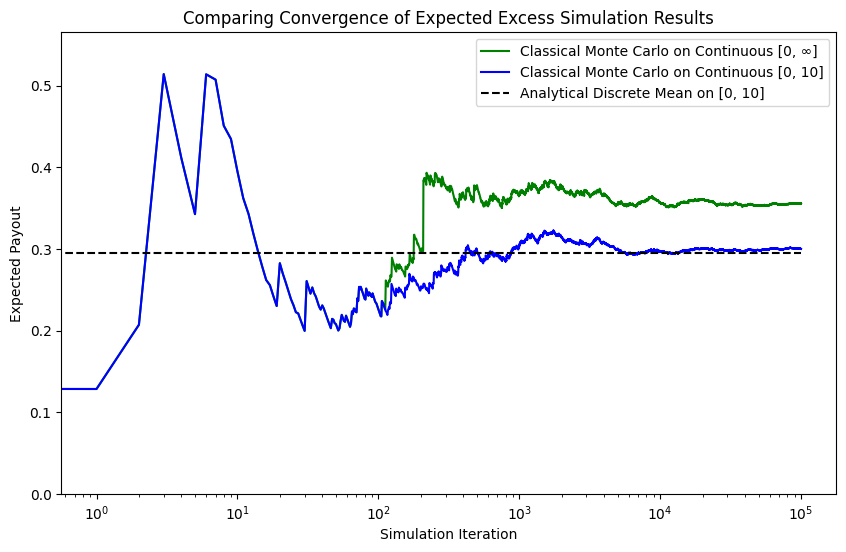

In [14]:
cmc_running_mean = np.cumsum(cmc_results) / np.arange(1, len(cmc_results) + 1)
cmc_running_mean_0_10 = np.cumsum(cmc_results_0_10) / np.arange(1, len(cmc_results_0_10) + 1)
cmc_x = range(cmc_samples)

# Plot the results
plt.figure(figsize=(10, 6)) #, dpi=300)
plt.plot(cmc_x, cmc_running_mean, 'g-', label='Classical Monte Carlo on Continuous [0, ∞]')
plt.plot(cmc_x, cmc_running_mean_0_10, 'b-', label='Classical Monte Carlo on Continuous [0, 10]')
# plt.plot(df_conv["shots"], df_conv["expected_payment"], 'r-', label='Quantum Monte Carlo on [0, 10]')
plt.hlines(y=expected_payout, xmin=0, xmax=cmc_samples, color='k', linestyle='--', label='Analytical Discrete Mean on [0, 10]')
plt.legend(loc='best')
plt.title('Comparing Convergence of Expected Excess Simulation Results')
plt.xlabel('Simulation Iteration')
plt.ylabel('Expected Payout')
plt.ylim(0, 1.1 * max(np.max(cmc_running_mean), np.max(cmc_running_mean_0_10)))
plt.xscale('log', base=10)
plt.axis([0, None, 0, None])
plt.show()

In [15]:
print(f"Classical Mean (Uncapped) = {cmc_running_mean[-1]}")
print(f"Classical Mean on [0, 10] = {expected_payout}")

Classical Mean (Uncapped) = 0.3555006436015467
Classical Mean on [0, 10] = 0.29557048928291246


In [16]:
cmc_results_0_10[-1]

np.float64(0.369043318418219)

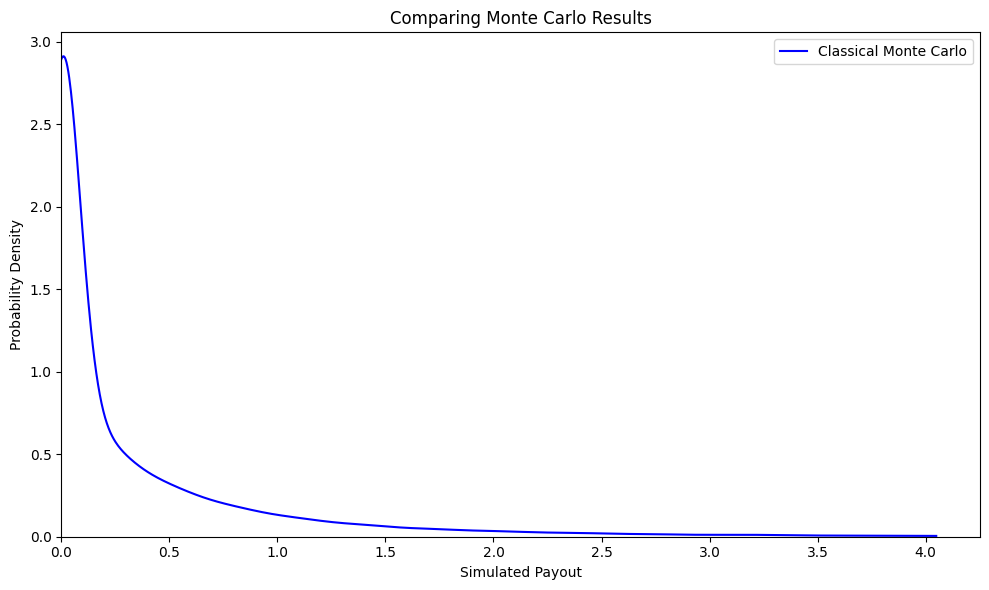

In [17]:
from scipy.stats import gaussian_kde

# Plot the results
plt.figure(figsize=(10, 6)) #, dpi=300)
cmc_results_kde = gaussian_kde(cmc_results)
cmc_x = np.linspace(0, np.percentile(cmc_results, 99) * 1.1, 1000)
plt.plot(cmc_x, cmc_results_kde(cmc_x), 'b-', label='Classical Monte Carlo')
# plt.plot(cmc_x, cmc_results_kde(cmc_x), 'r--', label='Quantum Monte Carlo')
plt.legend(loc='best')
plt.title('Comparing Monte Carlo Results')
plt.xlabel('Simulated Payout')
plt.ylabel('Probability Density')
plt.tight_layout()
plt.axis([0, None, 0, None])
plt.show()

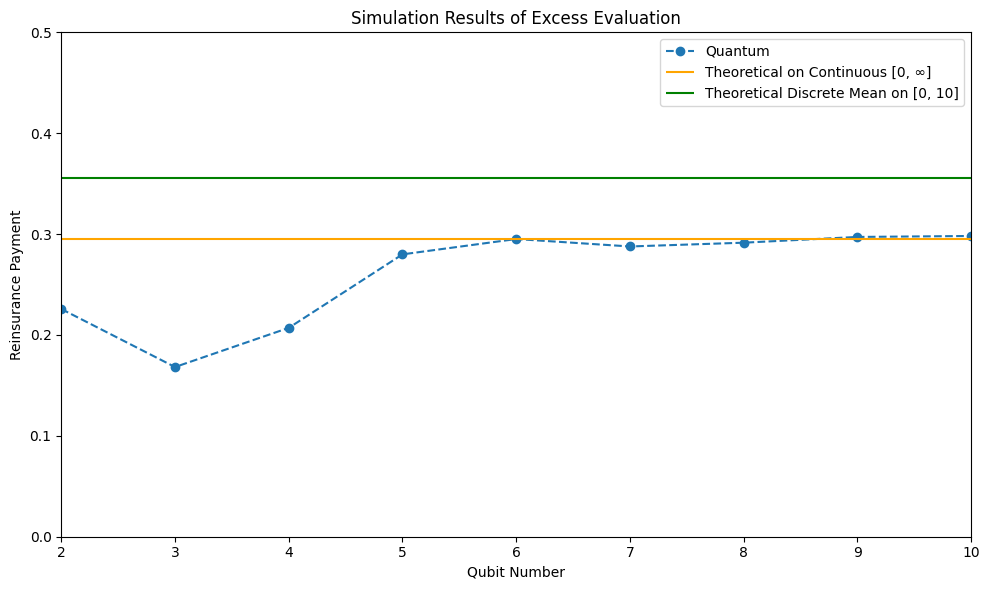

In [18]:
# Plot the results
plt.figure(figsize=(10, 6)) #, dpi=300)
plt.plot(e_pmt_qubits.keys(), e_pmt_qubits.values(), 'o--', label='Quantum')
plt.hlines(y=expected_payout, xmin=min(e_pmt_qubits.keys()), xmax=max(e_pmt_qubits.keys()), color='orange', linestyle='-', label='Theoretical on Continuous [0, ∞]')
plt.hlines(y=cmc_running_mean[-1], xmin=min(e_pmt_qubits.keys()), xmax=max(e_pmt_qubits.keys()), color='g', linestyle='-', label='Theoretical Discrete Mean on [0, 10]')
plt.title('Simulation Results of Excess Evaluation')
plt.xlabel('Qubit Number')
plt.ylabel('Reinsurance Payment')
plt.xlim(min(e_pmt_qubits.keys()), max(e_pmt_qubits.keys()))
# plt.ylim(0.9 * min(min(e_pmt_qubits.values()), expected_payout, cmc_running_mean[-1]), 1.1 * max(max(e_pmt_qubits.values()), expected_payout, cmc_running_mean[-1]))
plt.ylim(0, 0.5)
plt.legend(loc='best')
plt.tight_layout()
plt.show()